In [1]:
### Importamos librerías necesarias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV

In [2]:
# Leemos los csv con los datos de entrenamiento
ruta_train = "/mnt/c/Users/migue/Documents/Python/UNIR/TFE/datos_procesados_estaciones_train.csv"
df = pd.read_csv(ruta_train, sep=';', decimal='.')

# Leemos los csv con los datos de prueba
ruta_prueba = "/mnt/c/Users/migue/Documents/Python/UNIR/TFE/datos_procesados_estaciones_prueba.csv"
df_prueba = pd.read_csv(ruta_prueba, sep=';', decimal='.')

# Seleccionamos la estación 6667
df = df.loc[df['id'] == 6667]
df_prueba = df_prueba.loc[df_prueba['id'] == 6667]

In [3]:
# Mostramos los primeros datos
df.head()

,id,fecha,intensidad,ocupacion,carga,vmed,ANO,MES,DIA,HORA,MINUTO,DIA_SEMANA,TEMPERATURA,PRECIPITACION,FESTIVO,intensidad_media
455091,6667,2023-01-01 00:00:00,345.0,1.0,6.0,77.0,2023,1,1,0,0,6,7.6,0.0,0.0,189
455092,6667,2023-01-01 00:15:00,255.0,0.0,3.0,73.0,2023,1,1,0,15,6,7.6,0.0,0.0,163
455093,6667,2023-01-01 00:30:00,805.0,1.0,12.0,69.0,2023,1,1,0,30,6,7.6,0.0,0.0,632
455094,6667,2023-01-01 00:45:00,1496.0,2.0,22.0,66.0,2023,1,1,0,45,6,7.6,0.0,0.0,1229
455095,6667,2023-01-01 01:00:00,1688.0,3.0,27.0,64.0,2023,1,1,1,0,6,7.5,0.0,0.0,1701


In [4]:
# Mostramos los primeros datos
df_prueba.head()

,id,fecha,intensidad,ocupacion,carga,vmed,ANO,MES,DIA,HORA,MINUTO,DIA_SEMANA,TEMPERATURA,PRECIPITACION,FESTIVO,intensidad_media
112255,6667,2024-01-01 00:00:00,388.0,1.0,6.0,62.0,2024,1,1,0,0,0,6.5,0.0,1.0,194
112256,6667,2024-01-01 00:15:00,359.0,0.0,4.0,63.0,2024,1,1,0,15,0,6.5,0.0,1.0,175
112257,6667,2024-01-01 00:30:00,1020.0,1.0,17.0,60.0,2024,1,1,0,30,0,6.5,0.0,1.0,659
112258,6667,2024-01-01 00:45:00,1569.0,3.0,24.0,59.0,2024,1,1,0,45,0,6.5,0.0,1.0,1263
112259,6667,2024-01-01 01:00:00,1921.0,4.0,30.0,59.0,2024,1,1,1,0,0,6.3,0.0,1.0,1687


In [5]:
# Convertimos la columna 'fecha' a formato datetime
df['fecha'] = pd.to_datetime(df['fecha'])
df_prueba['fecha'] = pd.to_datetime(df_prueba['fecha'])

# Establecemos la fecha como índice
df = df.set_index('fecha')
df_prueba = df_prueba.set_index('fecha')

# Definimos la serie temporal de intensidad
intensidad_series = df['intensidad']
intensidad_series_prueba = df_prueba['intensidad']

# Dividimos los datos en entrenamiento y prueba
train_size = int(len(intensidad_series) * 0.8)
train_data = intensidad_series[:train_size]
test_data = intensidad_series[train_size:]

# Escalamos los datos
scaler = StandardScaler()
train_data_scaled = scaler.fit_transform(train_data.values.reshape(-1, 1))
test_data_scaled = scaler.transform(test_data.values.reshape(-1, 1))

forecast_steps = 4  # Número de pasos a predecir
window_size = 10  # Tamaño de la ventana de entrada

# Creamos los conjuntos de datos con ventanas deslizantes
def create_windowed_dataset(series, window_size, forecast_steps):
    X, y = [], []
    for i in range(len(series) - window_size - forecast_steps):
        X.append(series[i : i + window_size].flatten())  
        y.append(series[i + window_size : i + window_size + forecast_steps].flatten())  
    return np.array(X), np.array(y)

X_train, y_train = create_windowed_dataset(train_data_scaled, window_size, forecast_steps)
X_test, y_test = create_windowed_dataset(test_data_scaled, window_size, forecast_steps)

prueba_data = intensidad_series_prueba
prueba_data_scaled = scaler.fit_transform(prueba_data.values.reshape(-1, 1))

X_prueba, y_prueba = create_windowed_dataset(prueba_data_scaled, window_size, forecast_steps)

In [6]:
# Definir hiperparámetros a probar
param_grid = {
    'n_neighbors': [3, 5, 10, 15],  # Número de vecinos
    'weights': ['uniform', 'distance'],  # Pesos uniformes o por distancia
    'p': [1, 2]  # Distancia Manhattan (p=1) o Euclidiana (p=2)
}

# Usamos GridSearchCV para encontrar los mejores hiperparámetros
grid_search = GridSearchCV(
    KNeighborsRegressor(), 
    param_grid, 
    cv=3,  # Validación cruzada en 3 particiones
    scoring='neg_mean_absolute_error',  # Minimizar MAE
    n_jobs=-1  # Usar todos los núcleos disponibles
)

grid_search.fit(X_train, y_train)

# Mostrar mejores hiperparámetros encontrados
print(f"Mejores hiperparámetros: {grid_search.best_params_}")

# Entrenar modelo con los mejores parámetros
best_knn_model = grid_search.best_estimator_


Mejores hiperparámetros: {'n_neighbors': 15, 'p': 2, 'weights': 'distance'}


In [7]:
# Hacer predicciones
y_pred = best_knn_model.predict(X_test)

# Desescalar las predicciones y valores reales
y_pred_original = scaler.inverse_transform(y_pred)
y_test_original = scaler.inverse_transform(y_test)

# Calcular métricas
mae_steps, mse_steps, rmse_steps, r2_steps = [], [], [], []

for step in range(forecast_steps):
    mae_steps.append(mean_absolute_error(y_test[:, step], y_pred[:, step]))
    mse_steps.append(mean_squared_error(y_test[:, step], y_pred[:, step]))
    rmse_steps.append(np.sqrt(mse_steps[-1]))
    r2_steps.append(r2_score(y_test[:, step], y_pred[:, step]))

# Mostrar métricas por paso
for step in range(forecast_steps):
    print(
        f"Paso {step + 1} - MAE: {mae_steps[step]:.5f}, "
        f"MSE: {mse_steps[step]:.5f}, "
        f"RMSE: {rmse_steps[step]:.5f}, "
        f"R-squared: {r2_steps[step]:.5f}"
    )

Paso 1 - MAE: 0.15371, MSE: 0.04860, RMSE: 0.22045, R-squared: 0.95088
Paso 2 - MAE: 0.18691, MSE: 0.07292, RMSE: 0.27003, R-squared: 0.92631
Paso 3 - MAE: 0.21565, MSE: 0.09585, RMSE: 0.30959, R-squared: 0.90312
Paso 4 - MAE: 0.23850, MSE: 0.11507, RMSE: 0.33922, R-squared: 0.88369


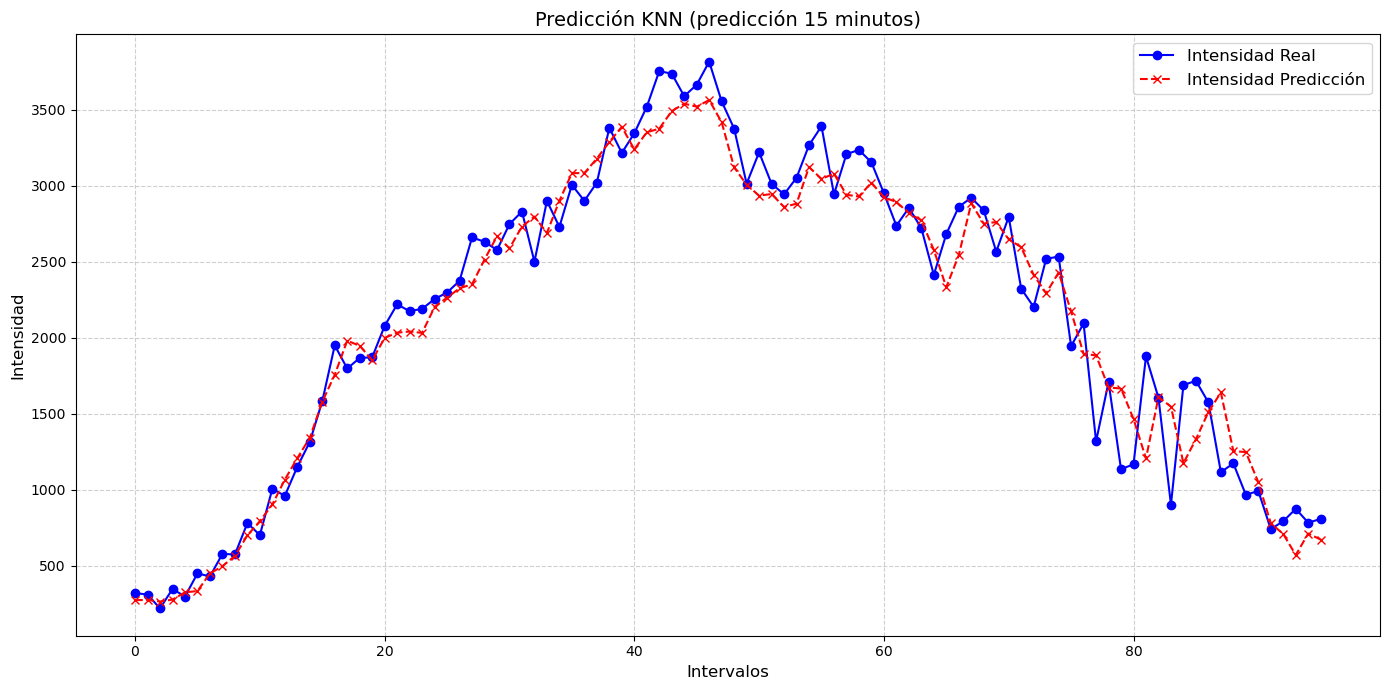

In [8]:
# Graficar resultados en la escala original
plt.figure(figsize=(14, 7))

# Mostrar solo los últimos 96 intervalos o el tamaño de las predicciones disponibles
num_intervals_to_show = min(96, len(y_test_original))

plt.plot(
    y_test_original[:num_intervals_to_show, 0], 
    label='Intensidad Real', 
    color='blue', 
    marker='o', 
    linestyle='-'
)
plt.plot(
    y_pred_original[:num_intervals_to_show, 0], 
    label='Intensidad Predicción', 
    color='red', 
    marker='x', 
    linestyle='--'
)

plt.title('Predicción KNN (predicción 15 minutos)', fontsize=14)
plt.xlabel('Intervalos', fontsize=12)
plt.ylabel('Intensidad', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

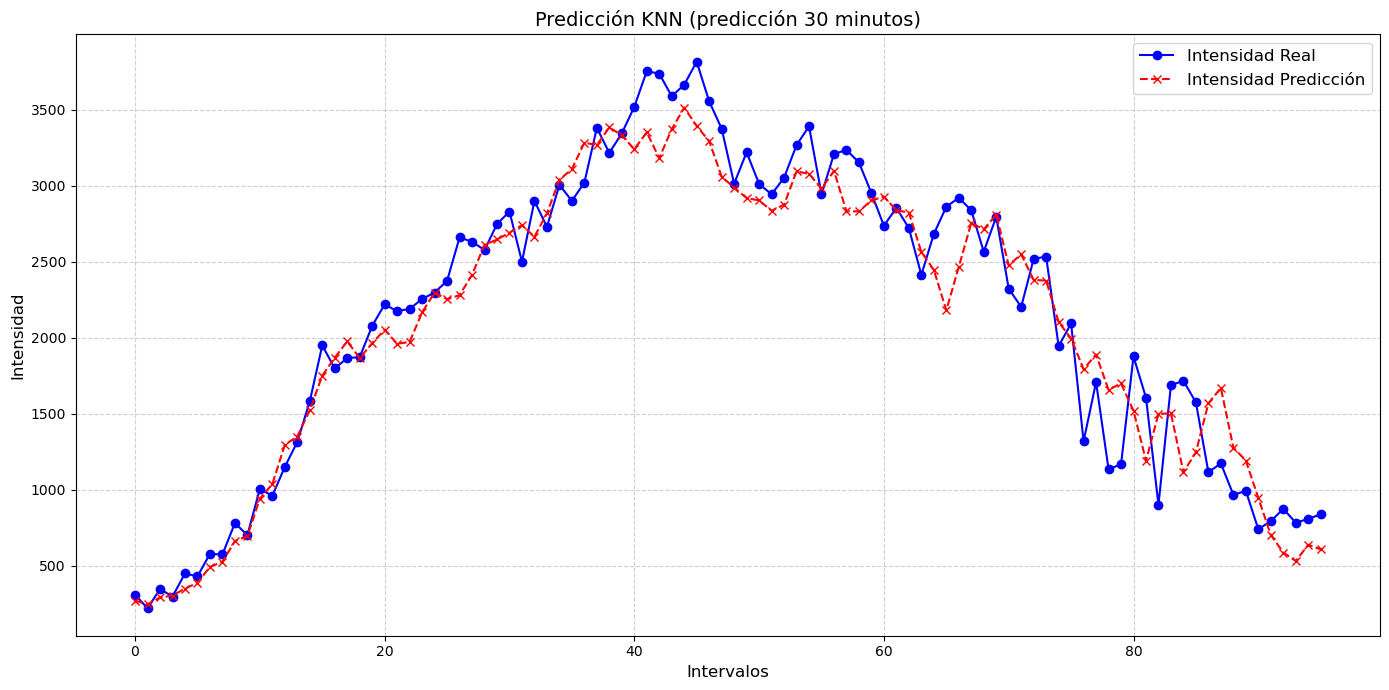

In [9]:
# Graficar resultados en la escala original
plt.figure(figsize=(14, 7))

# Mostrar solo los últimos 96 intervalos o el tamaño de las predicciones disponibles
num_intervals_to_show = min(96, len(y_test_original))

plt.plot(
    y_test_original[:num_intervals_to_show, 1], 
    label='Intensidad Real', 
    color='blue', 
    marker='o', 
    linestyle='-'
)
plt.plot(
    y_pred_original[:num_intervals_to_show, 1], 
    label='Intensidad Predicción', 
    color='red', 
    marker='x', 
    linestyle='--'
)

plt.title('Predicción KNN (predicción 30 minutos)', fontsize=14)
plt.xlabel('Intervalos', fontsize=12)
plt.ylabel('Intensidad', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

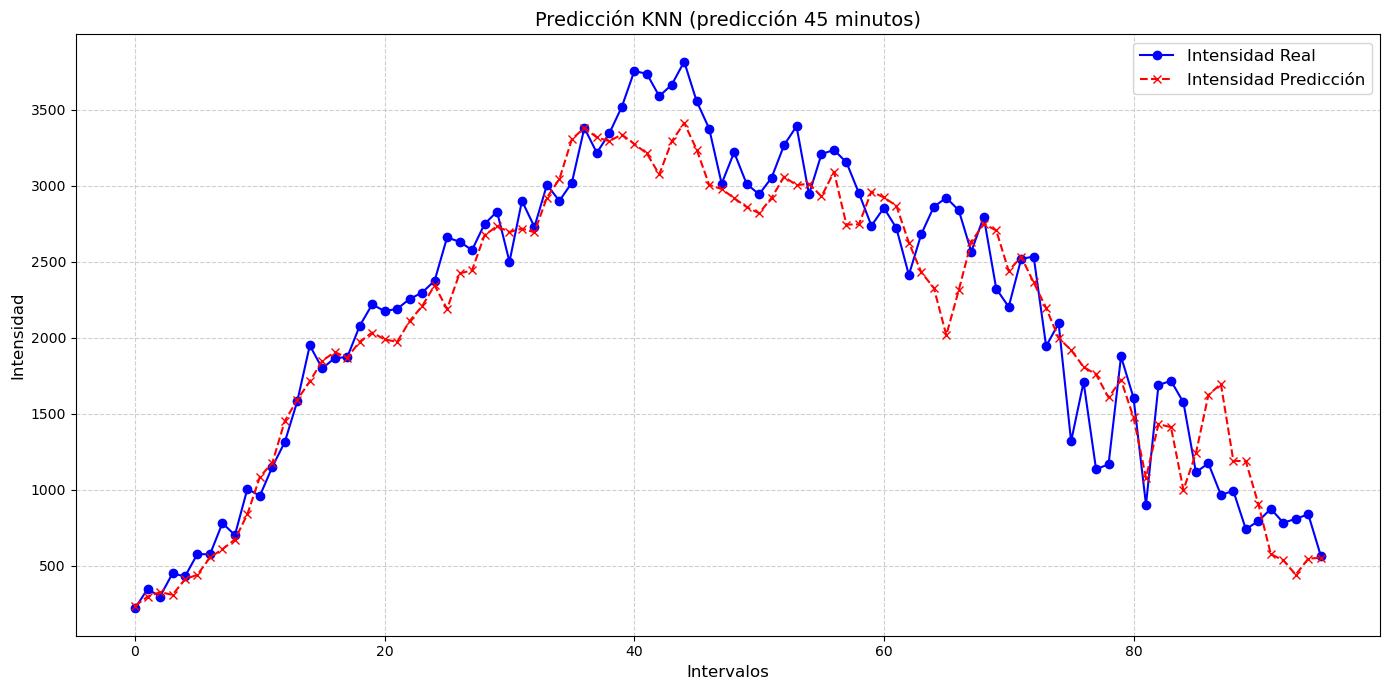

In [10]:
# Graficar resultados en la escala original
plt.figure(figsize=(14, 7))

# Mostrar solo los últimos 96 intervalos o el tamaño de las predicciones disponibles
num_intervals_to_show = min(96, len(y_test_original))

plt.plot(
    y_test_original[:num_intervals_to_show, 2], 
    label='Intensidad Real', 
    color='blue', 
    marker='o', 
    linestyle='-'
)
plt.plot(
    y_pred_original[:num_intervals_to_show, 2], 
    label='Intensidad Predicción', 
    color='red', 
    marker='x', 
    linestyle='--'
)

plt.title('Predicción KNN (predicción 45 minutos)', fontsize=14)
plt.xlabel('Intervalos', fontsize=12)
plt.ylabel('Intensidad', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

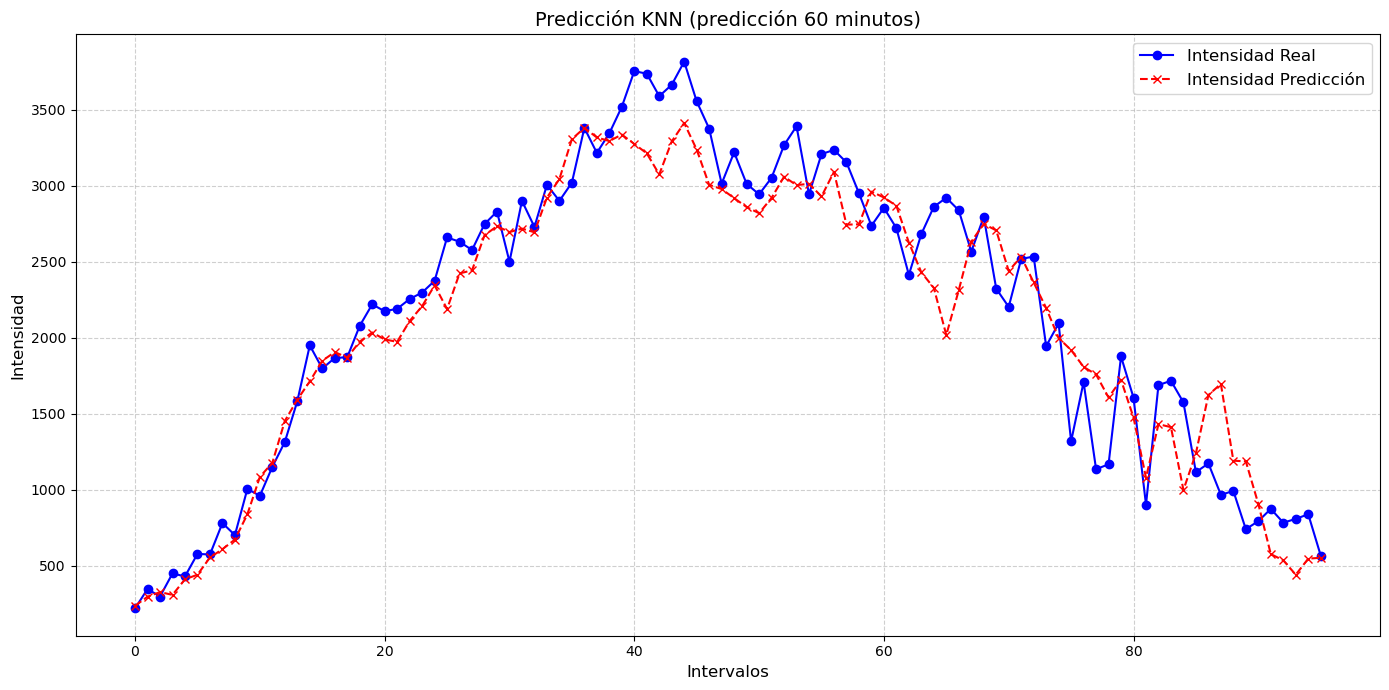

In [11]:
# Graficar resultados en la escala original
plt.figure(figsize=(14, 7))

# Mostrar solo los últimos 96 intervalos o el tamaño de las predicciones disponibles
num_intervals_to_show = min(96, len(y_test_original))

plt.plot(
    y_test_original[:num_intervals_to_show, 2], 
    label='Intensidad Real', 
    color='blue', 
    marker='o', 
    linestyle='-'
)
plt.plot(
    y_pred_original[:num_intervals_to_show, 2], 
    label='Intensidad Predicción', 
    color='red', 
    marker='x', 
    linestyle='--'
)

plt.title('Predicción KNN (predicción 60 minutos)', fontsize=14)
plt.xlabel('Intervalos', fontsize=12)
plt.ylabel('Intensidad', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

### Guardamos el modelo creado

In [12]:
# Ruta para guardar el modelo
ruta_modelo = '/mnt/c/Users/migue/Documents/Python/UNIR/TFE/Estacion 6667/best_KNN_model.pkl'

# Guardamos el modelo
joblib.dump(best_knn_model, ruta_modelo)

print(f"Modelo guardado en {ruta_modelo}")

Modelo guardado en /mnt/c/Users/migue/Documents/Python/UNIR/TFE/Estacion 6667/best_KNN_model.pkl


## Validación con un conjunto de datos no visto por el modelo

In [13]:
# Hacer predicciones
y_pred = best_knn_model.predict(X_prueba)

# Desescalar las predicciones y valores reales
y_pred_original = scaler.inverse_transform(y_pred)
y_prueba_original = scaler.inverse_transform(y_prueba)

# Calcular métricas
mae_steps, mse_steps, rmse_steps, r2_steps = [], [], [], []

for step in range(forecast_steps):
    mae_steps.append(mean_absolute_error(y_prueba[:, step], y_pred[:, step]))
    mse_steps.append(mean_squared_error(y_prueba[:, step], y_pred[:, step]))
    rmse_steps.append(np.sqrt(mse_steps[-1]))
    r2_steps.append(r2_score(y_prueba[:, step], y_pred[:, step]))

# Mostrar métricas por paso
for step in range(forecast_steps):
    print(
        f"Paso {step + 1} - MAE: {mae_steps[step]:.5f}, "
        f"MSE: {mse_steps[step]:.5f}, "
        f"RMSE: {rmse_steps[step]:.5f}, "
        f"R-squared: {r2_steps[step]:.5f}"
    )

Paso 1 - MAE: 0.14375, MSE: 0.04112, RMSE: 0.20277, R-squared: 0.95891
Paso 2 - MAE: 0.17880, MSE: 0.06434, RMSE: 0.25366, R-squared: 0.93571
Paso 3 - MAE: 0.21055, MSE: 0.08714, RMSE: 0.29520, R-squared: 0.91292
Paso 4 - MAE: 0.23887, MSE: 0.10896, RMSE: 0.33009, R-squared: 0.89113


#### Gráficas

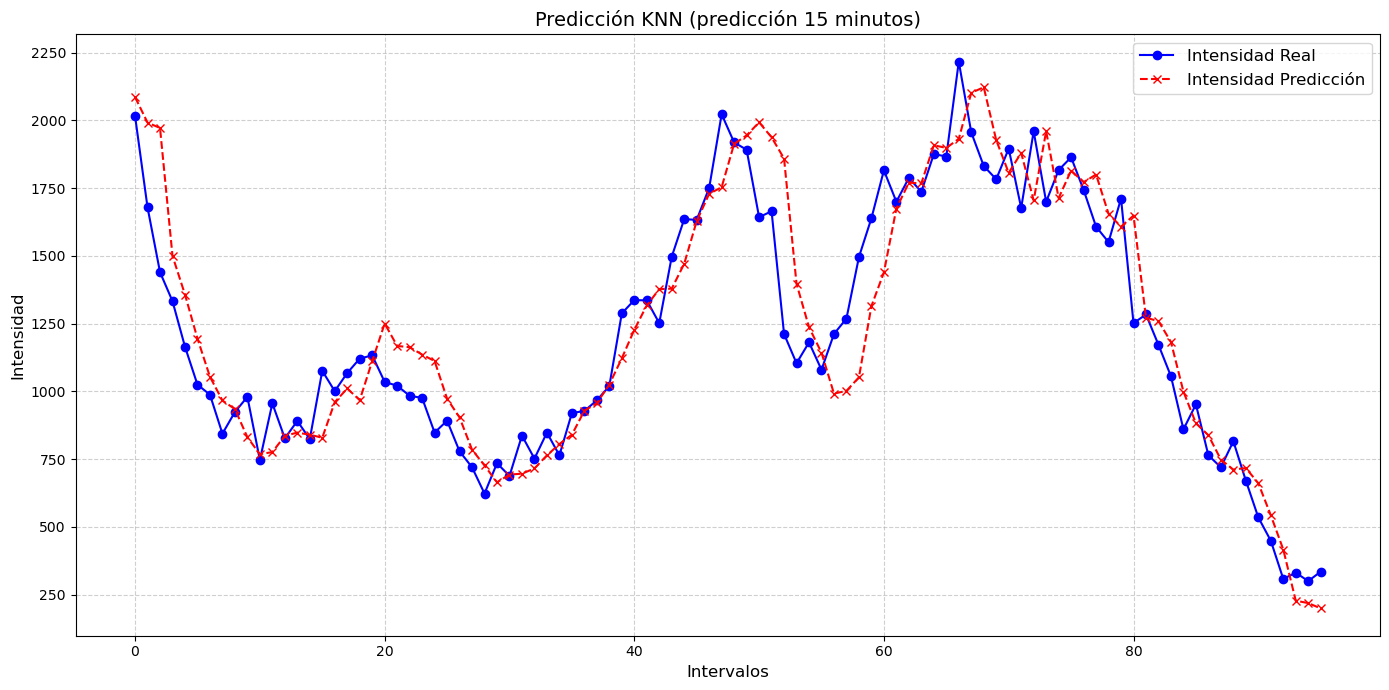

In [14]:
# Graficar resultados en la escala original
plt.figure(figsize=(14, 7))

# Mostrar solo los últimos 96 intervalos o el tamaño de las predicciones disponibles
num_intervals_to_show = min(96, len(y_prueba_original))

plt.plot(
    y_prueba_original[:num_intervals_to_show, 0], 
    label='Intensidad Real', 
    color='blue', 
    marker='o', 
    linestyle='-'
)

plt.plot(
    y_pred_original[:num_intervals_to_show, 0], 
    label='Intensidad Predicción', 
    color='red', 
    marker='x', 
    linestyle='--'
)

plt.title('Predicción KNN (predicción 15 minutos)', fontsize=14)
plt.xlabel('Intervalos', fontsize=12)
plt.ylabel('Intensidad', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

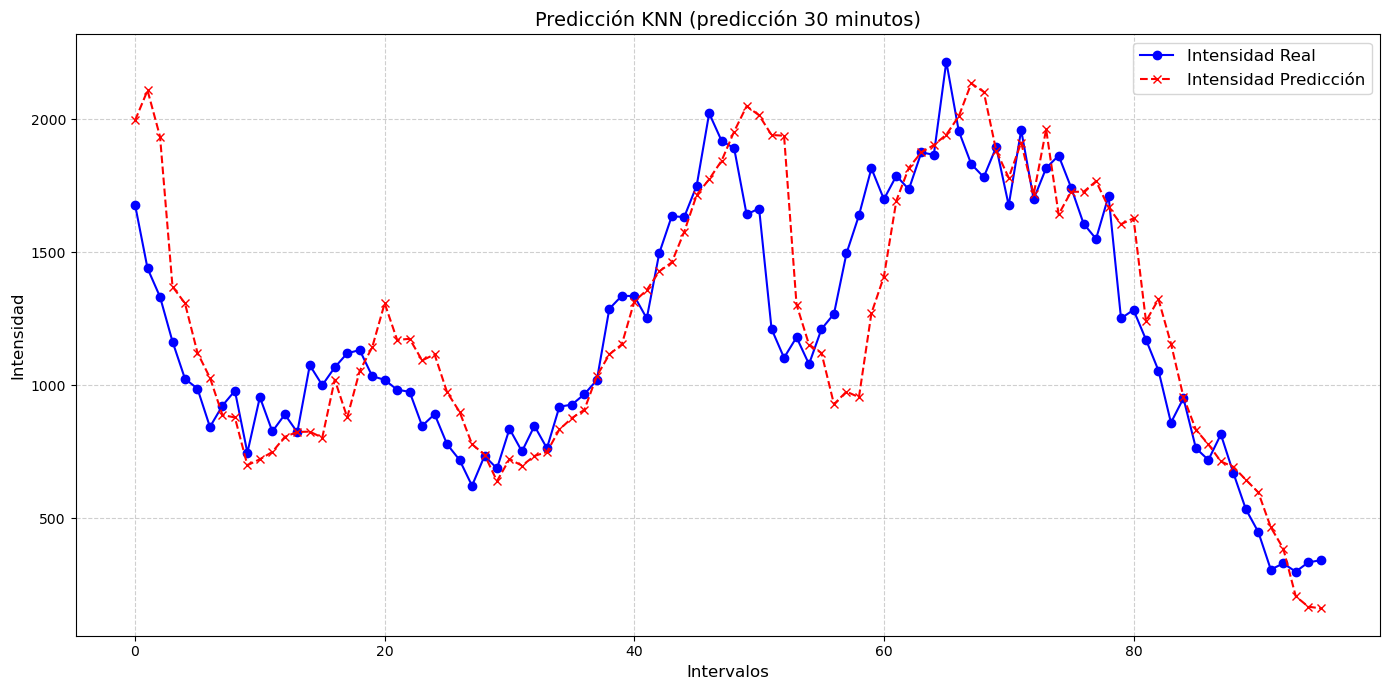

In [15]:
# Graficar resultados en la escala original
plt.figure(figsize=(14, 7))

# Mostrar solo los últimos 96 intervalos o el tamaño de las predicciones disponibles
num_intervals_to_show = min(96, len(y_prueba_original))

plt.plot(
    y_prueba_original[:num_intervals_to_show, 1], 
    label='Intensidad Real', 
    color='blue', 
    marker='o', 
    linestyle='-'
)

plt.plot(
    y_pred_original[:num_intervals_to_show, 1], 
    label='Intensidad Predicción', 
    color='red', 
    marker='x', 
    linestyle='--'
)

plt.title('Predicción KNN (predicción 30 minutos)', fontsize=14)
plt.xlabel('Intervalos', fontsize=12)
plt.ylabel('Intensidad', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

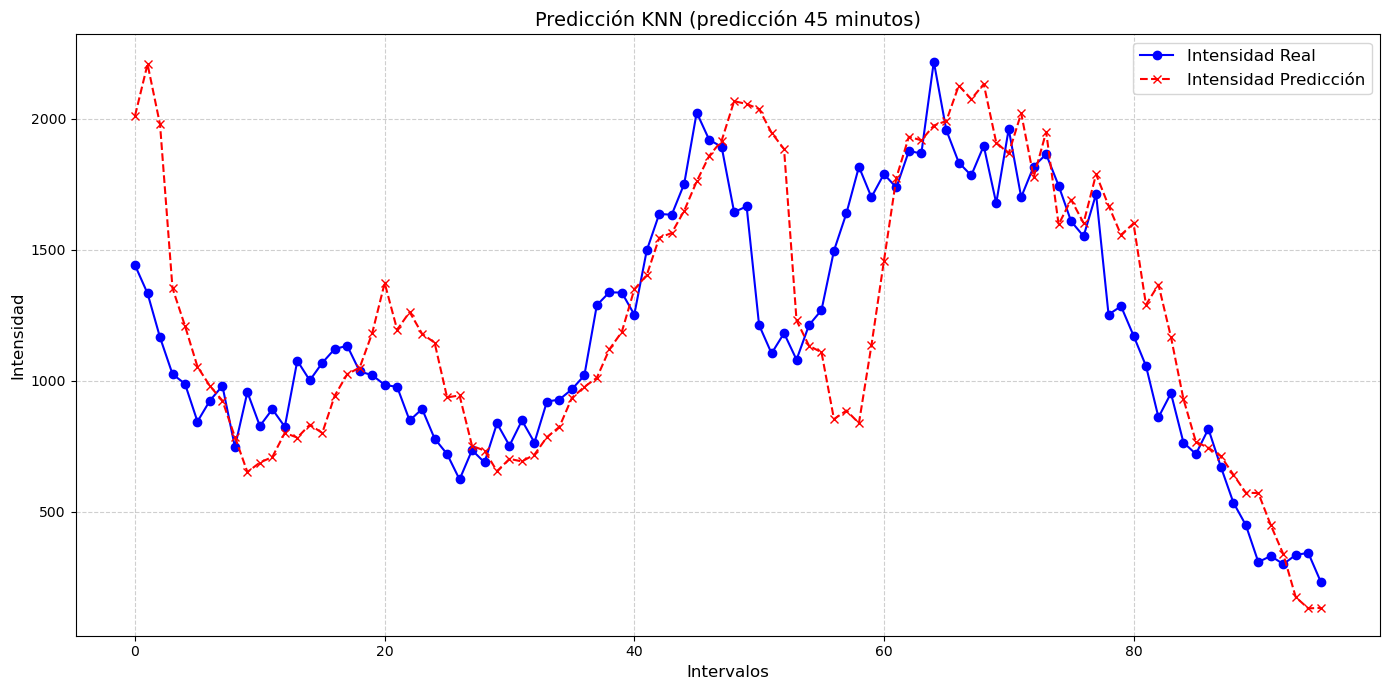

In [16]:
# Graficar resultados en la escala original
plt.figure(figsize=(14, 7))

# Mostrar solo los últimos 96 intervalos o el tamaño de las predicciones disponibles
num_intervals_to_show = min(96, len(y_prueba_original))

plt.plot(
    y_prueba_original[:num_intervals_to_show, 2], 
    label='Intensidad Real', 
    color='blue', 
    marker='o', 
    linestyle='-'
)

plt.plot(
    y_pred_original[:num_intervals_to_show, 2], 
    label='Intensidad Predicción', 
    color='red', 
    marker='x', 
    linestyle='--'
)

plt.title('Predicción KNN (predicción 45 minutos)', fontsize=14)
plt.xlabel('Intervalos', fontsize=12)
plt.ylabel('Intensidad', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

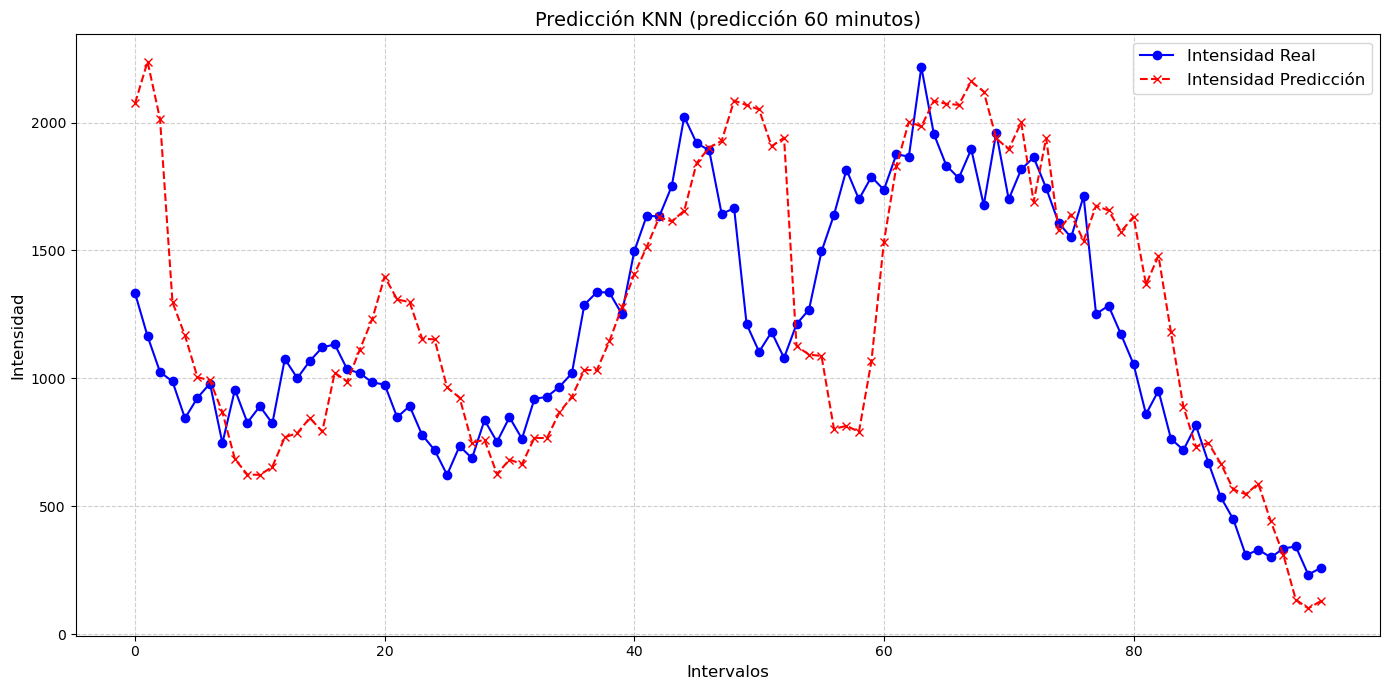

In [17]:
# Graficar resultados en la escala original
plt.figure(figsize=(14, 7))

# Mostrar solo los últimos 96 intervalos o el tamaño de las predicciones disponibles
num_intervals_to_show = min(96, len(y_prueba_original))

plt.plot(
    y_prueba_original[:num_intervals_to_show, 3], 
    label='Intensidad Real', 
    color='blue', 
    marker='o', 
    linestyle='-'
)

plt.plot(
    y_pred_original[:num_intervals_to_show, 3], 
    label='Intensidad Predicción', 
    color='red', 
    marker='x', 
    linestyle='--'
)

plt.title('Predicción KNN (predicción 60 minutos)', fontsize=14)
plt.xlabel('Intervalos', fontsize=12)
plt.ylabel('Intensidad', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

#### Prueba una única estación  
Probamos el modelo sobre la estación 3490 (Km 10.8 de la M-30).

In [18]:
# Leemos los csv con los datos de entrenamiento
ruta_estacion_prueba = "/mnt/c/Users/migue/Documents/Python/UNIR/TFE/datos_procesados_estaciones_prueba.csv"
df_estacion = pd.read_csv(ruta_estacion_prueba, sep=';', decimal='.')

# Creamos el conjunto con los datos de la estación 3490
datos_3490 = df_estacion[df_estacion['id'] == 3490]

In [19]:
# Preparamos los datos de la estación
# Nos aseguramos que la columna 'fecha' esté en formato datetime
datos_3490['fecha'] = pd.to_datetime(datos_3490['fecha'])

# Establecemos la fecha como índice
datos_3490 = datos_3490.set_index('fecha')

# Seleccionamos las columnas relevantes para el modelo
df_encoded_3490 = datos_3490['intensidad']

# Escalamos los datos
scaler = StandardScaler()
df_encoded_3490_data_scaled = scaler.fit_transform(df_encoded_3490.values.reshape(-1, 1))

X_3490, y_3490 = create_windowed_dataset(df_encoded_3490_data_scaled, window_size, forecast_steps)

/tmp/ipykernel_7951/2053242435.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  datos_3490['fecha'] = pd.to_datetime(datos_3490['fecha'])


In [20]:
# Hacer predicciones
y_pred = best_knn_model.predict(X_3490)

# Desescalar las predicciones y valores reales
y_pred_original = scaler.inverse_transform(y_pred)
y_3490_original = scaler.inverse_transform(y_3490)

# Calcular métricas
mae_steps, mse_steps, rmse_steps, r2_steps = [], [], [], []

for step in range(forecast_steps):
    mae_steps.append(mean_absolute_error(y_3490[:, step], y_pred[:, step]))
    mse_steps.append(mean_squared_error(y_3490[:, step], y_pred[:, step]))
    rmse_steps.append(np.sqrt(mse_steps[-1]))
    r2_steps.append(r2_score(y_3490[:, step], y_pred[:, step]))

# Mostrar métricas por paso
for step in range(forecast_steps):
    print(
        f"Paso {step + 1} - MAE: {mae_steps[step]:.5f}, "
        f"MSE: {mse_steps[step]:.5f}, "
        f"RMSE: {rmse_steps[step]:.5f}, "
        f"R-squared: {r2_steps[step]:.5f}"
    )

Paso 1 - MAE: 0.19458, MSE: 0.08879, RMSE: 0.29798, R-squared: 0.91127
Paso 2 - MAE: 0.25135, MSE: 0.13570, RMSE: 0.36837, R-squared: 0.86439
Paso 3 - MAE: 0.29852, MSE: 0.17757, RMSE: 0.42140, R-squared: 0.82255
Paso 4 - MAE: 0.33801, MSE: 0.21581, RMSE: 0.46455, R-squared: 0.78434


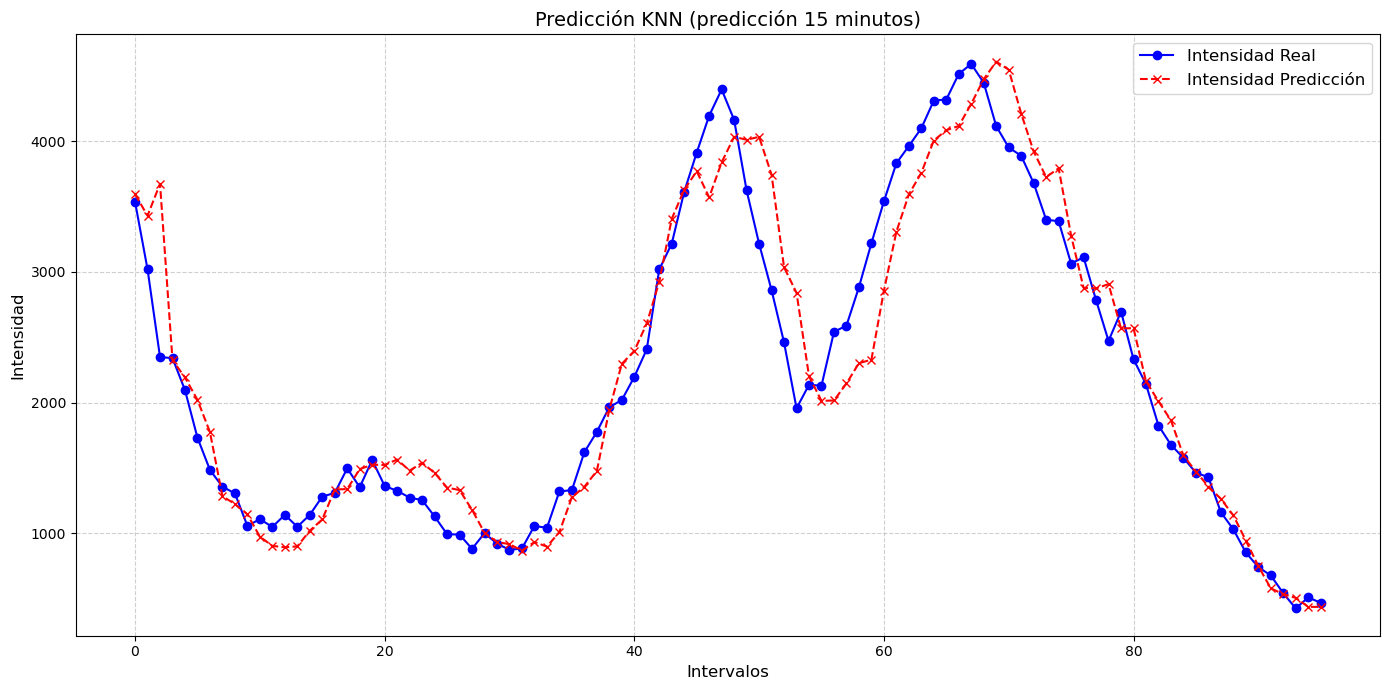

In [21]:
# Graficar resultados en la escala original
plt.figure(figsize=(14, 7))

# Mostrar solo los últimos 96 intervalos o el tamaño de las predicciones disponibles
num_intervals_to_show = min(96, len(y_3490_original))

plt.plot(
    y_3490_original[:num_intervals_to_show, 0], 
    label='Intensidad Real', 
    color='blue', 
    marker='o', 
    linestyle='-'
)

plt.plot(
    y_pred_original[:num_intervals_to_show, 0], 
    label='Intensidad Predicción', 
    color='red', 
    marker='x', 
    linestyle='--'
)

plt.title('Predicción KNN (predicción 15 minutos)', fontsize=14)
plt.xlabel('Intervalos', fontsize=12)
plt.ylabel('Intensidad', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

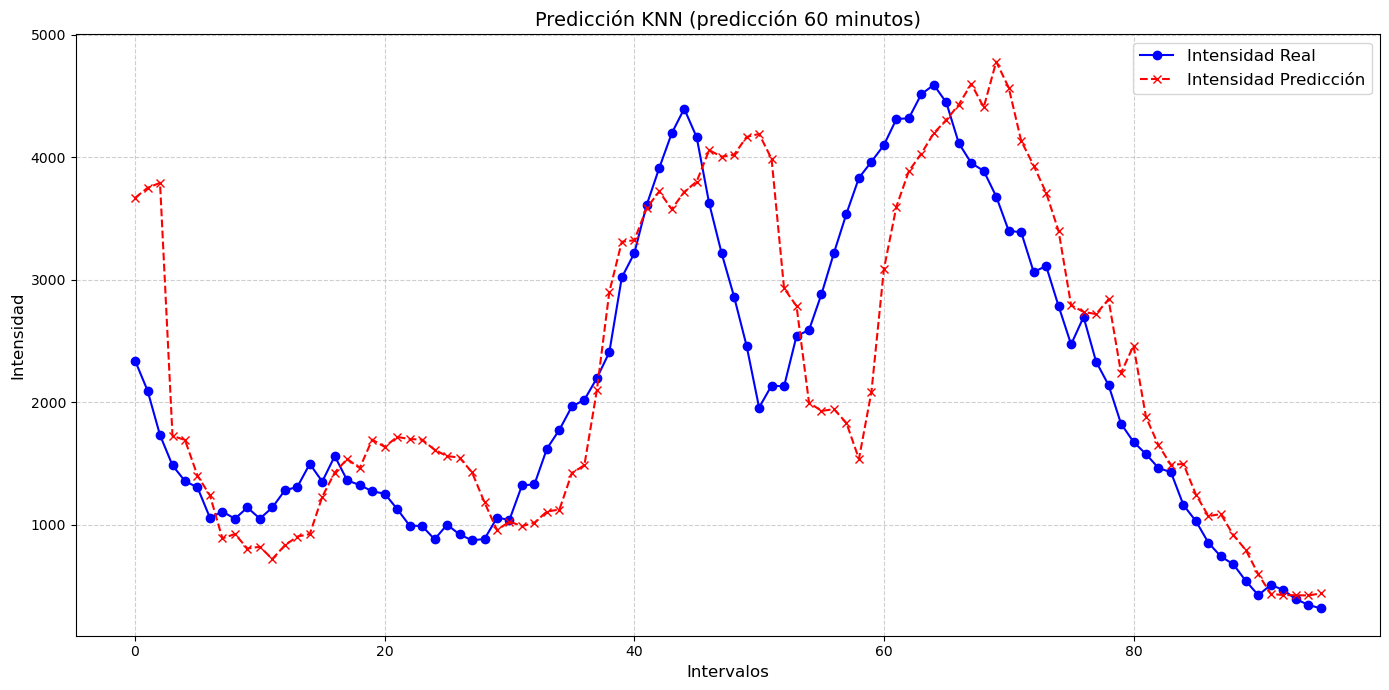

In [22]:
# Graficar resultados en la escala original
plt.figure(figsize=(14, 7))

# Mostrar solo los últimos 96 intervalos o el tamaño de las predicciones disponibles
num_intervals_to_show = min(96, len(y_3490_original))

plt.plot(
    y_3490_original[:num_intervals_to_show, 3], 
    label='Intensidad Real', 
    color='blue', 
    marker='o', 
    linestyle='-'
)

plt.plot(
    y_pred_original[:num_intervals_to_show, 3], 
    label='Intensidad Predicción', 
    color='red', 
    marker='x', 
    linestyle='--'
)

plt.title('Predicción KNN (predicción 60 minutos)', fontsize=14)
plt.xlabel('Intervalos', fontsize=12)
plt.ylabel('Intensidad', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()